# EXPLORATORY DATA ANALYSIS: what do the data tells us?

### IMPORTING LIBRARIES

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import yellowbrick
import shap
import vaex
import vaex.ml
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score, matthews_corrcoef
import xgboost as xgb
import plotly.io as pio

In [2]:
pd.set_option('display.max_columns',None)

### IMPORTING DATASET

In [24]:
df = pd.read_csv("SupplyChainDataset.csv")

###### Analyzing the dataset

In [27]:
#showing just the categorical variables
cat_col = []
for x in df.columns:
    if df[x].dtype == ('O'):
        cat_col.append(x)
        
print(len(cat_col),"Categorical variables: ",  cat_col,'\n')

num_col = []
for x in df.columns:
    if df[x].dtype != ('O'):
        num_col.append(x)
        
print(len(num_col),"Numerical variables: ",  num_col,'\n')

20 Categorical variables:  ['Type', 'Delivery Status', 'Category Name', 'Customer City', 'Customer Country', 'Customer Segment', 'Customer State', 'Customer Street', 'Department Name', 'Market', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Region', 'Order State', 'Order Status', 'Product Image', 'Product Name', 'shipping date (DateOrders)', 'Shipping Mode'] 

19 Numerical variables:  ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Late_delivery_risk', 'Category Id', 'Customer Id', 'Customer Zipcode', 'Department Id', 'Latitude', 'Longitude', 'Order Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Profit Ratio', 'Order Item Quantity', 'Order Item Total', 'Order Zipcode', 'Product Price', 'Product Status'] 



##### Changing dates in the right format - datetime 

In [89]:
import datetime as dt
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'])

##### Missing values

In [14]:
df.isna().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [15]:
#removing all the columns containing missing values 
df = df.dropna(axis=1, how='all')

###### Checking duplicates

In [18]:
df.duplicated().sum()

0

##### Removing Personal info columns

In [17]:
df = df.drop(['Customer Email', "Customer Fname", "Customer Lname", "Customer Password"], axis=1) 

##### Checking Correlation

C:\Users\gaiaa\AppData\Local\Temp/ipykernel_15828/513811219.py:16: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



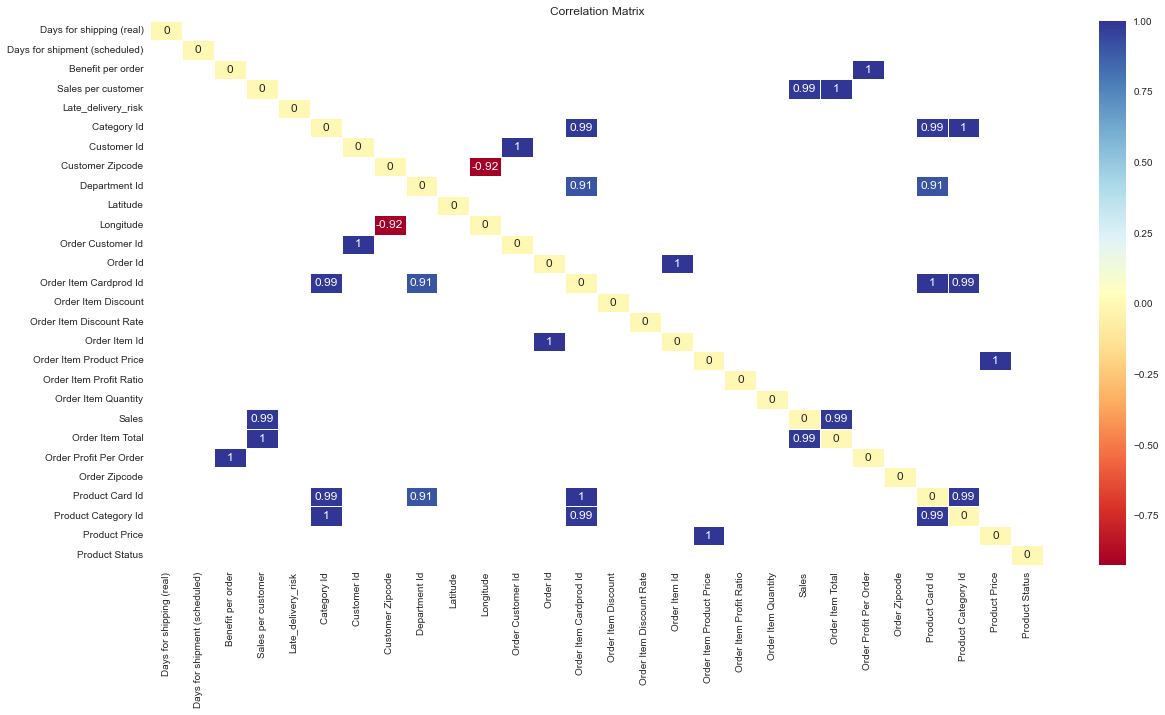

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'df' containing your data

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Filter the correlation matrix based on the desired range
filtered_matrix = correlation_matrix[
    (correlation_matrix > 0.90) | (correlation_matrix < -0.90)
]

# Set the diagonal values to zero
filtered_matrix.values[[range(filtered_matrix.shape[0])]*2] = 0

# Plot the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(filtered_matrix, annot=True, cmap="RdYlBu", linewidths=0.5)

plt.title("Correlation Matrix")
plt.show()

In [26]:
#Dropping variables with a correlation of 0.99 and 1
df = df.drop(['Order Profit Per Order', "Sales per customer", "Sales", "Product Category Id", "Product Card Id", "Order Item Cardprod Id","Order Customer Id","Order Item Id","Order Item Product Price"], axis=1) 

In [28]:
#Customer Country
x = df.pivot_table(index = ['Customer Country'], aggfunc ='size').reset_index(name="Count")
fig = px.bar(x, x="Customer Country", y= "Count" )
fig.show()

In [29]:
#First 20 destination country per order
oc = df.pivot_table(index=["Order Country"], aggfunc="size").reset_index(name="Count")
sorted_oc = oc.sort_values(by='Count', ascending=False)
sorted_oc.reset_index(drop = True)
sorted_oc = sorted_oc.head(20)
fig = px.bar(sorted_oc, x="Order Country", y= "Count" )
fig.show()

### ANALYZING THE COLUMN ORDER ID

In [56]:
df["Order Id"].value_counts()

48880    5
3605     5
28265    5
50037    5
27861    5
        ..
42011    1
42068    1
42072    1
42118    1
26118    1
Name: Order Id, Length: 65752, dtype: int64

Interestly, we can notice how the same order id is repeated multiple times. Since there are no duplicates in the dataset, this columns needs to be analyzed more in depth to understand better its meaning.
In the below cell we can see how many times unique order id are repeated. For example 30% of order ids are repeated once, while 17% are repeated 2/3/4/5. 

In [85]:
new_df = df.groupby('Order Id').size().reset_index(name="Count")
new_df = pd.DataFrame(new_df)
new_df

new_df["Count"].value_counts(normalize=True)

1    0.301892
4    0.178002
2    0.174094
3    0.173348
5    0.172664
Name: Count, dtype: float64

Here below we can see how many times unique order id are repeated. For example 30% of order ids are repeated once, while 17% are repeated 2/3/4/5

In [83]:
df[df["Order Id"]== 9][["Days for shipment (scheduled)","Delivery Status", "Shipping Mode", "Product Price", "Benefit per order"]]

,Days for shipment (scheduled),Delivery Status,Shipping Mode,Product Price,Benefit per order
77008,4,Late delivery,Standard Class,199.990005,96.000000
77009,4,Late delivery,Standard Class,199.990005,19.799999
89680,4,Late delivery,Standard Class,99.989998,3.800000


By filtering the dataset with an order Id that gets repeated multiple times, we noticed how all the columns reffering to the order as a whole contains the same values, while only the columns refferring to the specific items have different values

### GROUPED DATASET

In [110]:
agg_functions = {
    'Type': 'first',
    'Order Status': 'first',
    'Order City': 'first',
    'Customer City':'first',
    'Order State': 'first',
    'Customer State':'first',
    'Delivery Status': 'first',
    'Shipping Mode':'first',
    'Days for shipping (real)': 'first',
    'Days for shipment (scheduled)' :'first',
    'order date (DateOrders)': 'first',
    'Benefit per order': ['sum', 'median'],
    'Order Item Discount Rate': 'median',
    'Customer Segment': 'first',
    'Customer Id': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    'Category Name': lambda x: ','.join(x.unique()),
    # Add the rest of the categorical columns with the lambda function
    'Order Item Total': ['sum','median'],
    'Order Item Quantity': ['sum']
    # Add any additional numerical columns with the appropriate aggregation functions
}
# Group by 'Order Id' and apply the aggregation functions
grouped_df = df.groupby('Order Id').agg(agg_functions).reset_index()
grouped_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in grouped_df.columns]
grouped_df = grouped_df.drop(columns=["Order Id_"], axis=1)

In [111]:
grouped_df.to_csv("grouped_df_final.csv", index=False)

# Fraud Detection

### EXPLORATORY DATA ANALYSIS ON GROUPED DATASET

In [30]:
#Checking the relationship between the type of payment and the order status
order_status_fraud = grouped_df.groupby(['Order Status_first', 'Type_first']).size().to_frame('Count').reset_index()
g = px.bar(order_status_fraud, x = 'Order Status_first', y = 'Count', color = 'Type_first', barmode='group')
g.show()

We can notice how all the transfer payment (online) are either canceled, pending, processing or suspected_fraud
While all the cash payment are labelled as closed.
The debit card payment are under the label of complete or on hold.
The payment methods are under payment_review and pending_payment

### Plot the distribution of order status and delivery status. Are there any suspected fraud?

In [31]:
order_status_fraud = grouped_df.groupby(['Order Status_first', 'Delivery Status_first']).size().to_frame('Count').reset_index()
g = px.bar(order_status_fraud, x = 'Order Status_first', y = 'Count', color = 'Delivery Status_first', barmode='group')
g.show()
pio.write_image(g, 'plot.png')

The Plot shows that the suspected frauds are the only canceled delivery. Therefore, it possible to assume that the target variable has to be a binary one (Suspected and Not Suspected).

### Set Is_Fraud features and visualize its distribution.

In [32]:
grouped_df['Is_Fraud'] = grouped_df['Order Status_first'].apply(lambda x: 1 if x == 'SUSPECTED_FRAUD' else 0)

In [33]:
fraud_distribution = grouped_df.groupby('Is_Fraud').size().to_frame('Count').reset_index()
fig = px.bar(fraud_distribution, x = 'Is_Fraud', y = 'Count', width=400, height=400)
fig.update_layout(xaxis_visible=True, xaxis_showticklabels=True, title = 'Suspected Fraud Count for grouped df', legend_title="")
fig.show()
pio.write_image(fig, 'plot2.png')

In [114]:
grouped_df["Is_Fraud"].value_counts(normalize=True)

0    0.97737
1    0.02263
Name: Is_Fraud, dtype: float64

The dataset is highly unbalanced, with just 2,26% of the observations that are fraudolent. 

In [115]:
#Let's compare whether the percentage of frauds and not frauds are the same also in the original dataset
df['Is_Fraud'] = df['Order Status'].apply(lambda x: 1 if x == 'SUSPECTED_FRAUD' else 0)
fraud_distribution = df.groupby('Is_Fraud').size().to_frame('Count').reset_index()
df["Is_Fraud"].value_counts(normalize=True)

0    0.977498
1    0.022502
Name: Is_Fraud, dtype: float64

The percentages are almost the same between the grouped and the original dataset.

##### CORRELATION FOR THE GROUPED DATASET

From the correlation map, we can see 

In [116]:
#correlation matrix
corr_df = grouped_df.corr()
display(corr_df)
fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(corr_df, annot = True, fmt = '.2f')
fig.savefig("matrix.png")

fig.show()

,Days for shipping (real)_first,Days for shipment (scheduled)_first,Benefit per order_sum,Benefit per order_median,Order Item Discount Rate_median,Customer Id_first,Latitude_first,Longitude_first,Order Item Total_sum,Order Item Total_median,Order Item Quantity_sum,Is_Fraud
Days for shipping (real)_first,1.000000,0.515490,-0.008342,-0.007887,0.001734,0.003126,-0.006154,0.003795,-0.001324,0.006739,-0.003573,0.000734
Days for shipment (scheduled)_first,0.515490,1.000000,-0.000829,-0.002711,0.002465,-0.002386,-0.005905,0.004811,0.003909,0.012031,-0.005219,-0.002761
Benefit per order_sum,-0.008342,-0.000829,1.000000,0.691837,-0.024184,-0.042183,0.000670,-0.003862,0.199334,0.084095,0.135941,-0.002499
Benefit per order_median,-0.007887,-0.002711,0.691837,1.000000,-0.026503,0.008286,-0.003160,-0.002773,0.116049,0.175681,0.026143,-0.000504
Order Item Discount Rate_median,0.001734,0.002465,-0.024184,-0.026503,1.000000,0.007881,-0.006817,-0.001710,-0.096031,-0.083591,-0.025769,0.002467
Customer Id_first,0.003126,-0.002386,-0.042183,0.008286,0.007881,1.000000,0.003688,-0.003015,-0.214443,0.127086,-0.313305,0.004899
Latitude_first,-0.006154,-0.005905,0.000670,-0.003160,-0.006817,0.003688,1.000000,-0.528014,0.000555,0.002454,-0.001072,-0.005123
Longitude_first,0.003795,0.004811,-0.003862,-0.002773,-0.001710,-0.003015,-0.528014,1.000000,0.001272,-0.000745,0.004093,0.007484
Order Item Total_sum,-0.001324,0.003909,0.199334,0.116049,-0.096031,-0.214443,0.000555,0.001272,1.000000,0.399344,0.679921,-0.002085
Order Item Total_median,0.006739,0.012031,0.084095,0.175681,-0.083591,0.127086,0.002454,-0.000745,0.399344,1.000000,-0.086160,0.001562


C:\Users\gaiaa\AppData\Local\Temp/ipykernel_15828/2025904338.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



# STATISITCAL ANALYSIS OF THE ORIGINAL DATASET
- The aim was to demostrate the presence of stastically significance between the predictors and the target variable

## Is there a correlation between the numerical features and the target varaiable Is_Fraud? Let's check the p-value

Days for shipping (real) and Is_Fraud: t-test p-value=0.8869437666563207, Mann-Whitney U test p-value=0.9821850699786591
Days for shipment (scheduled) and Is_Fraud: t-test p-value=0.28719584647882584, Mann-Whitney U test p-value=0.2873703121613135
Benefit per order and Is_Fraud: t-test p-value=0.5226812349975967, Mann-Whitney U test p-value=0.3073542878528125
Sales per customer and Is_Fraud: t-test p-value=0.7633451674156061, Mann-Whitney U test p-value=0.5829636588362951
Late_delivery_risk and Is_Fraud: t-test p-value=0.0, Mann-Whitney U test p-value=0.0
Category Id and Is_Fraud: t-test p-value=0.48839569643069825, Mann-Whitney U test p-value=0.4969963744331678
Customer Id and Is_Fraud: t-test p-value=5.085813810581571e-05, Mann-Whitney U test p-value=4.379078914503168e-06
Department Id and Is_Fraud: t-test p-value=0.51852649020387, Mann-Whitney U test p-value=0.44477741288546213
Latitude and Is_Fraud: t-test p-value=0.10213546009120422, Mann-Whitney U test p-value=0.1286960953295874


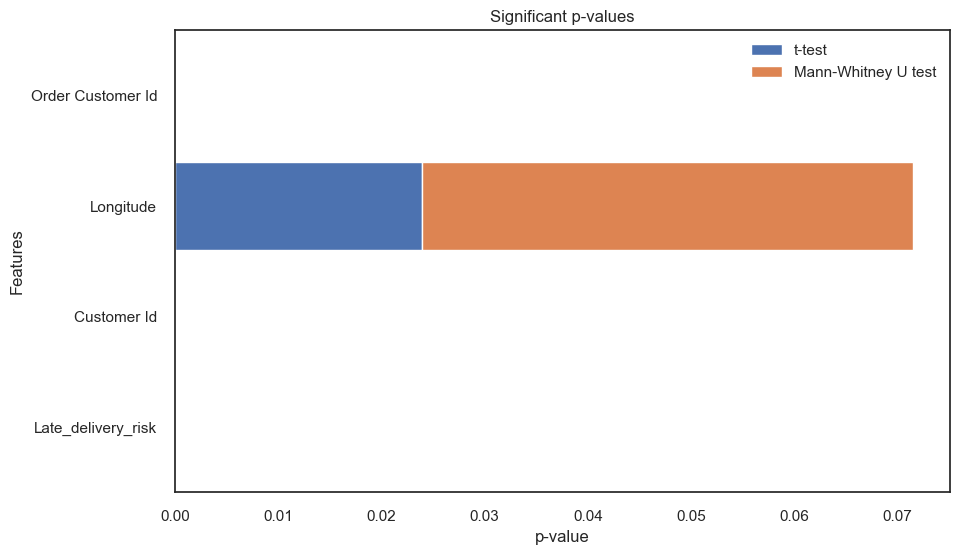

In [51]:
#compare the numeric distribution
from scipy.stats import ttest_ind, mannwhitneyu

def compare_distributions(data, target_col, feature_col):
    group1 = data[data[target_col] == 0][feature_col]
    group2 = data[data[target_col] == 1][feature_col]
    
    t_stat, t_p_value = ttest_ind(group1, group2, equal_var=False)
    mw_stat, mw_p_value = mannwhitneyu(group1, group2)
    
    return t_stat, t_p_value, mw_stat, mw_p_value
significant_results = []
# Perform t-test and Mann-Whitney U test for each numerical feature
numerical_features = grouped_df.select_dtypes(include=['int64', 'float64']).columns.drop('Is_Fraud')
for feature in numerical_features:
    t_stat, t_p_value, mw_stat, mw_p_value = compare_distributions(grouped_df, 'Is_Fraud', feature)
    print(f"{feature} and {target_col}: t-test p-value={t_p_value}, Mann-Whitney U test p-value={mw_p_value}")
    if t_p_value < 0.05 or mw_p_value < 0.05:
        significant_results.append((feature, t_p_value, mw_p_value))

# Plot significant p-values
plt.figure(figsize=(10, 6))
plt.barh([result[0] for result in significant_results],
         [result[1] for result in significant_results],
         label='t-test')
plt.barh([result[0] for result in significant_results],
         [result[2] for result in significant_results],
         left=[result[1] for result in significant_results],
         label='Mann-Whitney U test')
plt.xlabel('p-value')
plt.ylabel('Features')
plt.title('Significant p-values')
plt.legend()
plt.show()

## Is there a correlation between the categorical features and the target varaiable Is_Fraud? Let's check the chi-square test

                       Feature     Chi-square        p-value
18                Order Status  180519.000000   0.000000e+00
15     order date (DateOrders)  180519.000000   0.000000e+00
21  shipping date (DateOrders)  175323.662886   0.000000e+00
1              Delivery Status   92587.831917   0.000000e+00
10             Customer Street   24019.533281   0.000000e+00
13                  Order City   11748.567757   0.000000e+00
0                         Type   10882.639839   0.000000e+00
17                 Order State    4135.204481   0.000000e+00
3                Customer City    1981.036513  3.840060e-157
6               Customer Fname    1233.324712   6.332070e-23


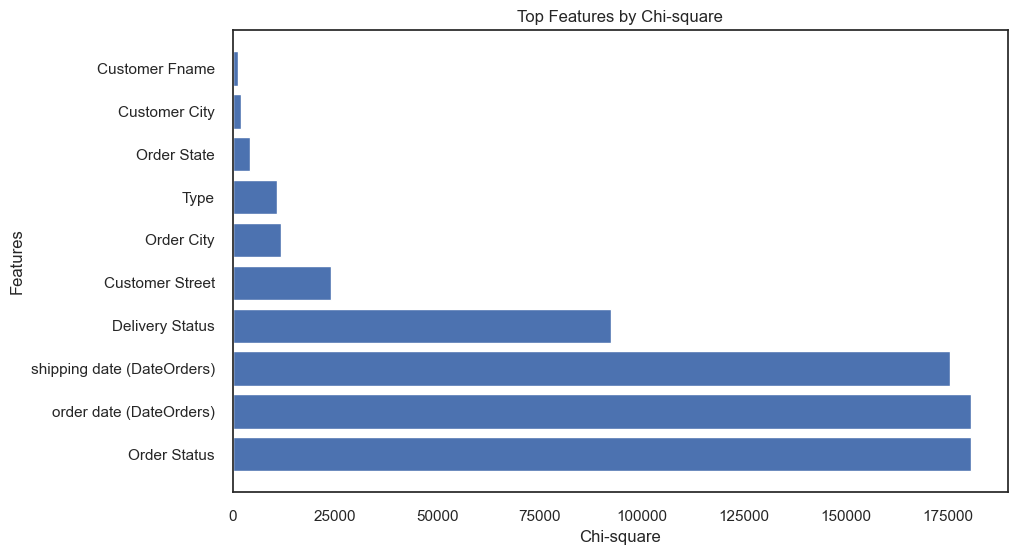

In [54]:
#fdefine a function to compute the chi_square_test using contigency tables
def chi_square_test(df, target_col, feature_col):
    contingency_table = pd.crosstab(df[target_col], df[feature_col])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2, p_value

chi_square_results = []
# Perform Chi-square test for each categorical feature
categorical_features = df.select_dtypes(include='object').columns
for feature in categorical_features:
    chi2, p_value = chi_square_test(df, 'Is_Fraud', feature)
    #print(f"Chi-square test for {feature} and {target_col}: chi2={chi2}, p-value={p_value}")
    chi_square_results.append((feature, chi2, p_value))
#Store the results in a DataFrame
results_df = pd.DataFrame(chi_square_results, columns=['Feature', 'Chi-square', 'p-value'])

# Sort the DataFrame by Chi-square value in descending order
results_df = results_df.sort_values(by='Chi-square', ascending=False)

# Display the top features (you can change the number of features to display)
top_features = results_df.head(10)
print(top_features)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Chi-square'])
plt.xlabel('Chi-square')
plt.ylabel('Features')
plt.title('Top Features by Chi-square')
plt.show()

# STATISITCAL ANALYSIS OF THE GROUPED DATASET
- We now move on to analyze if and how the shrinkage of the dataset has affected the statisitcs between the predictors and the target variable

## Preprocessing of the dataset for grouping the data around Order Id

In [5]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

grouped_df['InvoiceMonth'] = grouped_df['order date (DateOrders)_first'].apply(get_month)
grouping = grouped_df.groupby('Customer Id_first')['InvoiceMonth']
grouped_df['CohortMonth'] = grouping.transform('min')
grouping_days = grouped_df.groupby('Customer Id_first')['order date (DateOrders)_first']
grouped_df['Cohortdays']  = grouping_days.transform('min')
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    hour = df[column].dt.hour
    return year, month, date, hour

Invoice_Year, Invoice_Month, Invoice_Day, _ = get_date_int(grouped_df, 'order date (DateOrders)_first')
Cohort_Year, Cohort_Month , Cohort_day, _ = get_date_int(grouped_df, 'Cohortdays')
Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month
Day_Diff = Invoice_Day - Cohort_day
grouped_df['CohortIndex_months'] = Year_Diff*12 + Month_Diff +1
grouped_df['CohortIndex_days'] = Day_Diff.dt.days

class PreprocessDataFrame_regression:
    def __init__(self, df):
        self.df = df.copy()
  
    def process_datetetimes(self):
        self.df.order_date_DateOrders = pd.to_datetime(self.df.order_date_DateOrders)
        (self.df.order_date_DateOrders.astype(np.int64) / int(1e6)).astype('int64')
        return self.df

    def augment_with_network_features(self):
        self.df['Source'] = ('LA' + self.df['Latitude_first'].astype('str') + '-' + 'LO' + self.df['Longitude_first'].astype('str'))
        G = nx.from_pandas_edgelist(self.df, source='Source', target='Order City_first')
        self.df['Source_Centrality'] = self.df.Source.map(dict(G.degree))
        return self.df

#grouped_df = PreprocessDataFrame_regression(grouped_df).drop_canceled()
grouped_df = PreprocessDataFrame_regression(grouped_df).augment_with_network_features()

## Is there a correlation between the numerical features and the target varaiable Is_Fraud? Let's check the p-value

Order Id_ and Is_Fraud: t-test p-value=0.97510903488525, Mann-Whitney U test p-value=0.9669724193448004
Days for shipping (real)_first and Is_Fraud: t-test p-value=0.8664105499904585, Mann-Whitney U test p-value=0.8100578955295394
Benefit per order_sum and Is_Fraud: t-test p-value=0.489919812652595, Mann-Whitney U test p-value=0.39530019000275585
Benefit per order_median and Is_Fraud: t-test p-value=0.8657222409218394, Mann-Whitney U test p-value=0.5654240676894206
Order Item Discount Rate_median and Is_Fraud: t-test p-value=0.5219020800097762, Mann-Whitney U test p-value=0.47217968923939113
Customer Id_first and Is_Fraud: t-test p-value=0.2085092623218602, Mann-Whitney U test p-value=0.09081560277326028
Latitude_first and Is_Fraud: t-test p-value=0.19509890386321949, Mann-Whitney U test p-value=0.38588826515277863
Longitude_first and Is_Fraud: t-test p-value=0.05854998252747135, Mann-Whitney U test p-value=0.052863731961310875
Order Item Total_sum and Is_Fraud: t-test p-value=0.559949

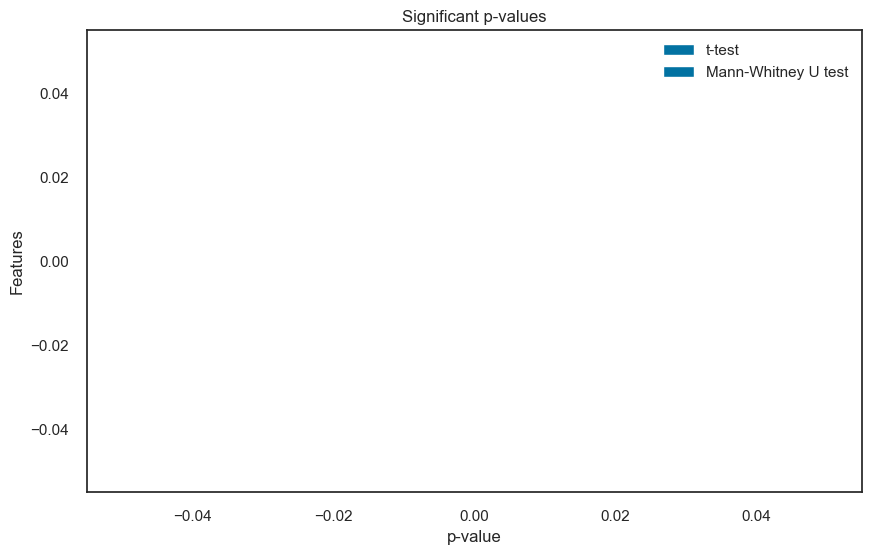

In [65]:
def compare_distributions(data, target_col, feature_col):
    group1 = data[data[target_col] == 0][feature_col]
    group2 = data[data[target_col] == 1][feature_col]
    
    t_stat, t_p_value = ttest_ind(group1, group2, equal_var=False)
    mw_stat, mw_p_value = mannwhitneyu(group1, group2)
    
    return t_stat, t_p_value, mw_stat, mw_p_value
significant_results = []
# Perform t-test and Mann-Whitney U test for each numerical feature
numerical_features = grouped_df.select_dtypes(include=['int64', 'float64']).columns.drop('Is_Fraud')
for feature in numerical_features:
    t_stat, t_p_value, mw_stat, mw_p_value = compare_distributions(grouped_df, 'Is_Fraud', feature)
    print(f"{feature} and {target_col}: t-test p-value={t_p_value}, Mann-Whitney U test p-value={mw_p_value}")
    if t_p_value < 0.05 or mw_p_value < 0.05:
        significant_results.append((feature, t_p_value, mw_p_value))

# Plot significant p-values
plt.figure(figsize=(10, 6))
plt.barh([result[0] for result in significant_results],
         [result[1] for result in significant_results],
         label='t-test')
plt.barh([result[0] for result in significant_results],
         [result[2] for result in significant_results],
         left=[result[1] for result in significant_results],
         label='Mann-Whitney U test')
plt.xlabel('p-value')
plt.ylabel('Features')
plt.title('Significant p-values')
plt.legend()
plt.show()

## Is there a correlation between the categorical features and the target varaiable Is_Fraud? Let's check the chi-square test

                   Feature    Chi-square   p-value
1       Order Status_first  64385.000000  0.000000
6    Delivery Status_first  64385.000000  0.000000
10                  Source  11990.845319  0.065991
9   Category Name_<lambda>  11326.824979  0.000181
0               Type_first   4345.822176  0.000000
2         Order City_first   3523.006677  0.791430
4        Order State_first   1234.060819  0.001198
3      Customer City_first    590.718381  0.194280
5     Customer State_first     43.536150  0.534057
7      Shipping Mode_first      4.889498  0.180070


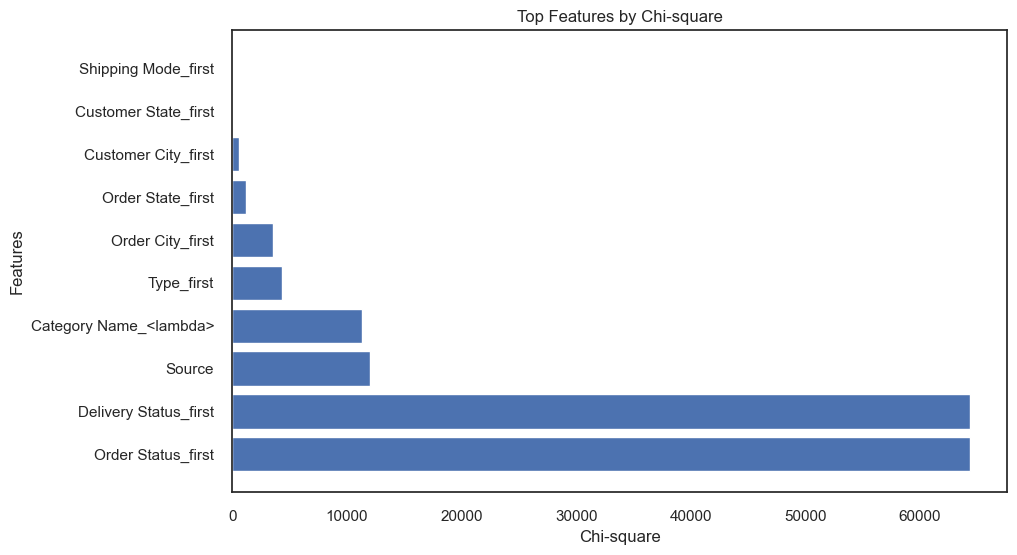

In [66]:
#fdefine a function to compute the chi_square_test using contigency tables
def chi_square_test(df, target_col, feature_col):
    contingency_table = pd.crosstab(df[target_col], df[feature_col])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2, p_value

chi_square_results = []
# Perform Chi-square test for each categorical feature
categorical_features = grouped_df.select_dtypes(include='object').columns
for feature in categorical_features:
    chi2, p_value = chi_square_test(grouped_df, 'Is_Fraud', feature)
    #print(f"Chi-square test for {feature} and {target_col}: chi2={chi2}, p-value={p_value}")
    chi_square_results.append((feature, chi2, p_value))
#Store the results in a DataFrame
results_df = pd.DataFrame(chi_square_results, columns=['Feature', 'Chi-square', 'p-value'])

# Sort the DataFrame by Chi-square value in descending order
results_df = results_df.sort_values(by='Chi-square', ascending=False)

# Display the top features (you can change the number of features to display)
top_features = results_df.head(10)
print(top_features)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Chi-square'])
plt.xlabel('Chi-square')
plt.ylabel('Features')
plt.title('Top Features by Chi-square')
plt.show()

# REGRESSION EXPLORATORY ANALYSIS

In [ ]:
grouped_df = pd.read_csv("grouped_df_final.csv")

In [ ]:
# Calculate the percentage distribution
percentage_distribution = df_regression['Days for shipping (real)_first'].value_counts(normalize=True) * 100

# Create a bar chart using Plotly Express
fig = px.bar(x=percentage_distribution.index, y=percentage_distribution.values, labels={'x': 'Days of Delivery', 'y': 'Percentage'}, text=percentage_distribution.values.round(2))
fig.update_layout(title='Distribution of Days of Delivery')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
# Display the chart
fig.show()

In [ ]:
# Calculate the percentage distribution
percentage_distribution = df['Days for shipping (real)'].value_counts(normalize=True) * 100

# Create a bar chart using Plotly Express
fig = px.bar(x=percentage_distribution.index, y=percentage_distribution.values, labels={'x': 'Days of Delivery', 'y': 'Percentage'}, text=percentage_distribution.values.round(2))
fig.update_layout(title='Distribution of Days of Delivery - Original Dataset')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Display the chart
fig.show()
pio.write_image(fig, 'bar_chart_delivery_original_dataset.png')

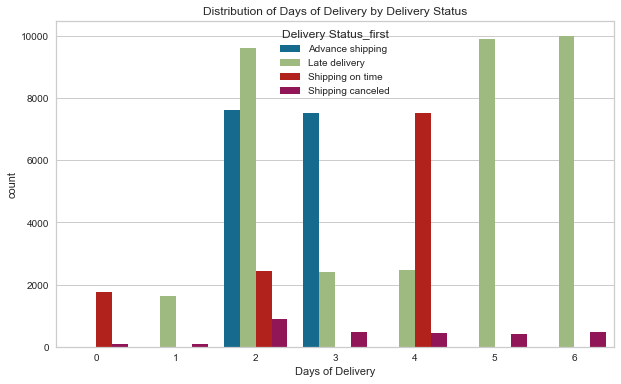

In [10]:
# Create a bar chart using Seaborn to check the distribution of days by dleivery status
plt.figure(figsize=(10, 6))
sns.countplot(data=df_regression, x='Days for shipping (real)_first', hue='Delivery Status_first')
plt.xlabel('Days of Delivery')
plt.title('Distribution of Days of Delivery by Delivery Status')
plt.show()

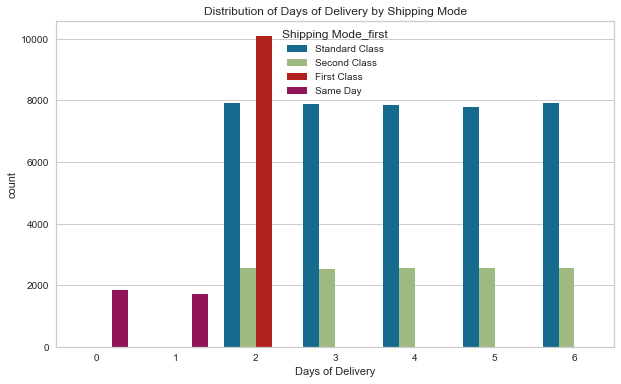

In [9]:
# Create a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df_regression, x='Days for shipping (real)_first', hue='Shipping Mode_first')
plt.xlabel('Days of Delivery')
plt.title('Distribution of Days of Delivery by Shipping Mode')
plt.show()

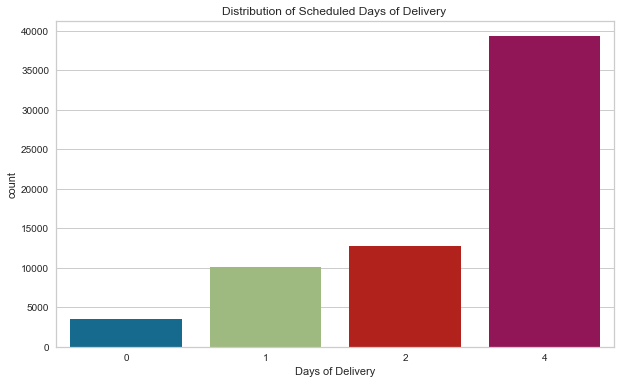

In [12]:
#What about the scheduled days of delivery? Are they different from the real days of delivery?
plt.figure(figsize=(10, 6))
sns.countplot(data=df_regression, x='Days for shipment (scheduled)_first')
plt.xlabel('Days of Delivery')
plt.title('Distribution of Scheduled Days of Delivery ')
plt.savefig("schedule.png")
plt.show()